In [1]:
import anndata
import os
import requests

def read_link(link, save_path):
    if not os.path.exists(save_path):
        response = requests.get(link)
        with open(save_path, "wb") as f:
            f.write(response.content)

    return anndata.read_h5ad(save_path)

MOBSC_sce = read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad")
MOBSP_sce = read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")

exper = {
    "sc": read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad"),
    "sp": read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")
    }

We haven't implemented differential variance in the current copula estimator! This is a simple extension -- let's make sure to add it.

In [2]:
from scdesigner.simulators import NegBinCopulaSimulator

formulas = {"sc": "~ cellType", "sp": "~ bs(spatial1, df=40) + bs(spatial2, df=40)"}
sims = {k: NegBinCopulaSimulator(epochs=5) for k in exper.keys()}
{v.fit(exper[k], formulas[k]) for k, v in sims.items()}

{None}

In [3]:
sims["sc"]

scDesigner simulator object with
    method: 'Negtive Binomial Copula'
    formula: '~ cellType'
    copula formula: 'None'
    parameters: 'coefficient', 'dispersion', 'covariance'

We need also a function to get the mean matrices. This is like "predict" in R.

In [4]:
means = {k: v.predict(exper[k].obs)["mean"] for k, v in sims.items()}

In [5]:
means

{'sc':                         Grin2b     Prkca      Ano3     Gria3     Kank3  \
 WT1_AAACCTGAGCTGCGAA  2.108742  1.111137  0.791100  0.722850  0.747857   
 WT1_AAACCTGGTTTGGCGC  2.108742  1.111137  0.791100  0.722850  0.747857   
 WT1_AAACGGGAGATCCGAG  2.108742  1.111137  0.791100  0.722850  0.747857   
 WT1_AAACGGGGTAAGTGGC  2.108742  1.111137  0.791100  0.722850  0.747857   
 WT1_AAAGATGTCATCGGAT  0.845731  0.221018  0.071971  0.073927  0.176121   
 ...                        ...       ...       ...       ...       ...   
 OC2_TAAGTGCGTTTGTTGG  0.322528  0.229099  0.132982  0.123246  0.136437   
 OC2_TACGGTAGTAAATGTG  0.322528  0.229099  0.132982  0.123246  0.136437   
 OC2_TACTTACGTAGGCATG  0.322528  0.229099  0.132982  0.123246  0.136437   
 OC2_TAGTTGGTCGCGATCG  0.322528  0.229099  0.132982  0.123246  0.136437   
 OC2_TTGCGTCAGGATCGCA  0.322528  0.229099  0.132982  0.123246  0.136437   
 
                           Penk     Icam5    Sema3c     Kcnb2  Il1rapl1  ...  \
 WT1_AAACCTG

In [6]:
import tangram as tg
from copy import deepcopy

mean_adata = {k: deepcopy(v) for k, v in exper.items()}
for k in exper.keys():
    mean_adata[k].X = means[k]

tg.pp_adatas(exper["sc"], exper["sp"])
adata_map = tg.map_cells_to_space(exper["sc"], exper["sp"])

INFO:root:182 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:182 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 182 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.672, KL reg: 0.059
Score: 0.947, KL reg: 0.000
Score: 0.951, KL reg: 0.000
Score: 0.951, KL reg: 0.000
Score: 0.951, KL reg: 0.000
Score: 0.951, KL reg: 0.000
Score: 0.952, KL reg: 0.000
Score: 0.952, KL reg: 0.000
Score: 0.952, KL reg: 0.000
Score: 0.952, KL reg: 0.000


INFO:root:Saving results..


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


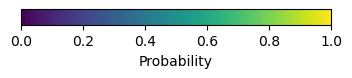

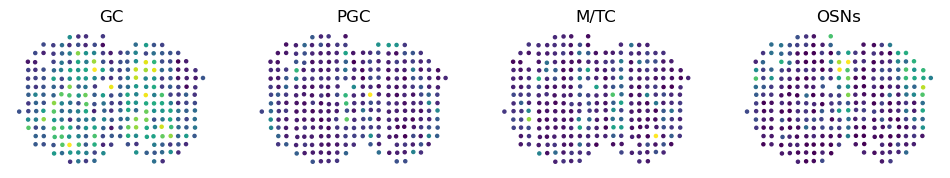

In [7]:
import tangram.plot_utils as pl

pl.plot_cell_annotation(adata_map, exper["sp"], x="spatial1", y="spatial2", ncols=4)

In [8]:
cell_types = list(exper["sc"].obs["cell_type"].dtype.categories)
cell_types

n_cells = len(exper["sc"])
# for n in range(n_cells):
    